In [1]:
import os
import glob
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from quickstats.utils.data_conversion import root2array
from itertools import combinations, permutations

In [2]:
directorytJ = "/eos/user/x/xianglon/ttHCP/hdf5/true_jets"

filestJ_mc16d = glob.glob(os.path.join(directorytJ, "mc16d*.h5"))
filestJ_mc16a = glob.glob(os.path.join(directorytJ, "mc16a*.h5"))
filestJ_mc16test = glob.glob(os.path.join(directorytJ, "*031*.h5"))

filestJ = filestJ_mc16test

df_tJ = pd.DataFrame()
current_max_event_id = 0

for file in filestJ:
    print(f"Processing file: {file}")
    df_tJ_piece = pd.read_hdf(file, key='df')
    df_tJ_piece['event'] += current_max_event_id
    current_max_event_id = df_tJ_piece['event'].max() + 1
    
    df_tJ = pd.concat([df_tJ, df_tJ_piece], ignore_index=True)

df_tJ = df_tJ.reset_index(drop=True)
df_tJ['jet_index'] = df_tJ.groupby('event').cumcount()

df_tJ = df_tJ[(df_tJ['HGamAntiKt4TruthWZJetsAuxDyn.eta'] > -2.5) & (df_tJ['HGamAntiKt4TruthWZJetsAuxDyn.eta'] < 2.5) & (df_tJ['HGamAntiKt4TruthWZJetsAuxDyn.pt'] > 25)]

Processing file: /eos/user/x/xianglon/ttHCP/hdf5/true_jets/mc16e.PowhegPy8_ttH125_fixweight.MxAODDetailedNoSkim.e7488_s3126_r10724_p4180_h028.031.h5


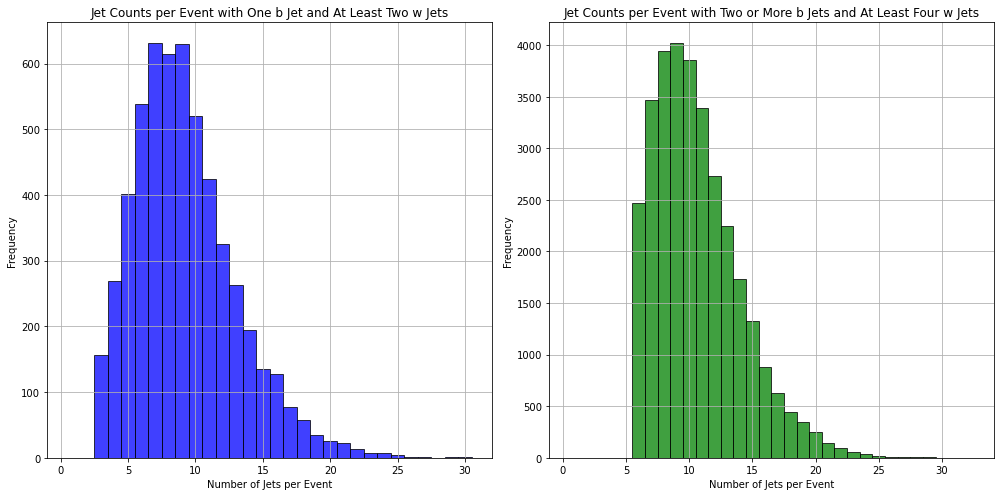

One b jet and at least two w jets event counts:
3     157
4     269
5     402
6     538
7     631
8     614
9     630
10    520
11    425
12    325
13    263
14    194
15    135
16    127
17     77
18     58
19     35
20     26
21     22
22     14
23      7
24      8
25      5
26      1
27      1
29      1
30      1
Name: total_jets, dtype: int64

Two or more b jets and at least four w jets event counts:
6     2467
7     3466
8     3940
9     4020
10    3854
11    3394
12    2736
13    2247
14    1732
15    1326
16     876
17     625
18     440
19     346
20     246
21     143
22      96
23      59
24      34
25      17
26      12
27      11
28       4
29       5
31       1
32       1
Name: total_jets, dtype: int64


In [3]:
def count_jets(group):
    b_jets = group['HGamAntiKt4TruthWZJetsAuxDyn.HadronConeExclTruthLabelID'] == 5
    w_jets = group['HGamAntiKt4TruthWZJetsAuxDyn.HadronConeExclTruthLabelID'] != 5
    return pd.Series({
        'b_jets': b_jets.sum(),
        'w_jets': w_jets.sum(),
        'total_jets': len(group)
    })

jet_counts = df_tJ.groupby('event').apply(count_jets)

one_b_two_w_events = jet_counts[(jet_counts['b_jets'] == 1) & (jet_counts['w_jets'] >= 2)]
two_b_four_w_events = jet_counts[(jet_counts['b_jets'] >= 2) & (jet_counts['w_jets'] >= 4)]

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.hist(one_b_two_w_events['total_jets'], bins=np.arange(0.5, one_b_two_w_events['total_jets'].max() + 1.5), alpha=0.75, color='blue', edgecolor='black')
plt.title('Jet Counts per Event with One b Jet and At Least Two w Jets')
plt.xlabel('Number of Jets per Event')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(two_b_four_w_events['total_jets'], bins=np.arange(0.5, two_b_four_w_events['total_jets'].max() + 1.5), alpha=0.75, color='green', edgecolor='black')
plt.title('Jet Counts per Event with Two or More b Jets and At Least Four w Jets')
plt.xlabel('Number of Jets per Event')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

print("One b jet and at least two w jets event counts:")
print(one_b_two_w_events['total_jets'].value_counts().sort_index())

print("\nTwo or more b jets and at least four w jets event counts:")
print(two_b_four_w_events['total_jets'].value_counts().sort_index())

In [4]:
num_events_one_b_two_w = len(one_b_two_w_events)
num_events_two_b_four_w = len(two_b_four_w_events)

print(f"Total number of events with one b jet and at least two w jets: {num_events_one_b_two_w}")
print(f"Total number of events with two or more b jets and at least four w jets: {num_events_two_b_four_w}")

Total number of events with one b jet and at least two w jets: 5486
Total number of events with two or more b jets and at least four w jets: 32098


In [6]:
def calculate_invariant_mass(px, py, pz, energy):
    mass2 = energy**2 - (px**2 + py**2 + pz**2)
    if mass2 >= 0:
        return np.sqrt(mass2)
    else:
        return np.nan

def calculate_kinematics(pt, eta, phi, mass):
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    energy = np.sqrt(px**2 + py**2 + pz**2 + mass**2)
    return px, py, pz, energy

def chi2(top_mass, W_mass, top_width, W_width, bjet, wjets):
    b_px, b_py, b_pz, b_energy = calculate_kinematics(
        bjet['HGamAntiKt4TruthWZJetsAuxDyn.pt'], bjet['HGamAntiKt4TruthWZJetsAuxDyn.eta'],
        bjet['HGamAntiKt4TruthWZJetsAuxDyn.phi'], bjet['HGamAntiKt4TruthWZJetsAuxDyn.m'])
    w1_px, w1_py, w1_pz, w1_energy = calculate_kinematics(
        wjets.iloc[0]['HGamAntiKt4TruthWZJetsAuxDyn.pt'], wjets.iloc[0]['HGamAntiKt4TruthWZJetsAuxDyn.eta'],
        wjets.iloc[0]['HGamAntiKt4TruthWZJetsAuxDyn.phi'], wjets.iloc[0]['HGamAntiKt4TruthWZJetsAuxDyn.m'])
    w2_px, w2_py, w2_pz, w2_energy = calculate_kinematics(
        wjets.iloc[1]['HGamAntiKt4TruthWZJetsAuxDyn.pt'], wjets.iloc[1]['HGamAntiKt4TruthWZJetsAuxDyn.eta'],
        wjets.iloc[1]['HGamAntiKt4TruthWZJetsAuxDyn.phi'], wjets.iloc[1]['HGamAntiKt4TruthWZJetsAuxDyn.m'])
    # m_{bq_1q_2}
    total_px = b_px + w1_px + w2_px
    total_py = b_py + w1_py + w2_py
    total_pz = b_pz + w1_pz + w2_pz
    total_energy = b_energy + w1_energy + w2_energy
    top_mass_calculated = calculate_invariant_mass(total_px, total_py, total_pz, total_energy)
    w_mass_calculated = calculate_invariant_mass(
        w1_px + w2_px, w1_py + w2_py, w1_pz + w2_pz, w1_energy + w2_energy)

    if np.isnan(top_mass_calculated) or np.isnan(w_mass_calculated):
        return np.inf

    chi2_top = ((top_mass_calculated - top_mass) / top_width) ** 2
    chi2_W = ((w_mass_calculated - W_mass) / W_width) ** 2
    return chi2_top + chi2_W

top_mass = 169800
W_mass = 81000
top_width = 29000
W_width = 18500

best_triplets = []

events_processed_with_one_bjet = 0
events_with_valid_triplets = 0
events_skipped_due_to_no_valid_triplets = 0

for event_id, group in df_tJ.groupby('event'):
    bjets = group[group['HGamAntiKt4TruthWZJetsAuxDyn.HadronConeExclTruthLabelID'] == 5]
    wjets = group[group['HGamAntiKt4TruthWZJetsAuxDyn.HadronConeExclTruthLabelID'] != 5]
    
    num_bjets = len(bjets)
    num_wjets = len(wjets)
    
    if num_bjets >= 2 and num_wjets >= 4:
        triplet_candidates = []
        for bjet_idx in bjets.index:
            for wjet_pair in combinations(wjets.index, 2):
                triplet = {'bjet_idx': bjet_idx, 'wjet_indices': wjet_pair}
                triplet_candidates.append(triplet)
        chi2_list = []
        for triplet in triplet_candidates:
            bjet = bjets.loc[triplet['bjet_idx']]
            wjets_pair = wjets.loc[list(triplet['wjet_indices'])].reset_index(drop=True)
            chi2_value = chi2(top_mass, W_mass, top_width, W_width, bjet, wjets_pair)
            chi2_list.append({'chi2': chi2_value, 'triplet': triplet})
        chi2_list.sort(key=lambda x: x['chi2'])
        selected_triplets = []
        used_wjets = set()
        for item in chi2_list:
            triplet = item['triplet']
            wjet_indices = set(triplet['wjet_indices'])
            if not wjet_indices & used_wjets:
                selected_triplets.append(triplet)
                used_wjets.update(wjet_indices)
            if len(selected_triplets) == 2:
                break
        if len(selected_triplets) == 2:
            # 分配标签
            labels = [1, 2]
            for triplet, label in zip(selected_triplets, labels):
                bjet = bjets.loc[triplet['bjet_idx']].copy()
                wjets_pair = wjets.loc[list(triplet['wjet_indices'])].copy()
                bjet['label'] = label
                wjets_pair['label'] = label
                combined_triplet = pd.concat([bjet.to_frame().T, wjets_pair], ignore_index=True)
                best_triplets.append(combined_triplet)
                
    elif num_bjets == 1 and num_wjets >= 2:
        events_processed_with_one_bjet += 1
        triplet_candidates = []
        bjet_idx = bjets.index[0]
        for wjet_pair in combinations(wjets.index, 2):
            triplet = {'bjet_idx': bjet_idx, 'wjet_indices': wjet_pair}
            triplet_candidates.append(triplet)
        chi2_list = []
        for triplet in triplet_candidates:
            bjet = bjets.loc[triplet['bjet_idx']]
            wjets_pair = wjets.loc[list(triplet['wjet_indices'])].reset_index(drop=True)
            chi2_value = chi2(top_mass, W_mass, top_width, W_width, bjet, wjets_pair)
            if np.isfinite(chi2_value):
                chi2_list.append({'chi2': chi2_value, 'triplet': triplet})
        if chi2_list:
            events_with_valid_triplets += 1
            chi2_list.sort(key=lambda x: x['chi2'])
            best_triplet = chi2_list[0]['triplet']
            bjet = bjets.loc[best_triplet['bjet_idx']].copy()
            wjets_pair = wjets.loc[list(best_triplet['wjet_indices'])].copy()
            bjet['label'] = 1
            wjets_pair['label'] = 1
            combined_triplet = pd.concat([bjet.to_frame().T, wjets_pair], ignore_index=True)
            best_triplets.append(combined_triplet)
        else:
            events_skipped_due_to_no_valid_triplets += 1
        
    else:
        continue

print(f"Number of events processed with one b jet and at least two w jets: {events_processed_with_one_bjet}")
print(f"Number of events with valid triplets: {events_with_valid_triplets}")
print(f"Number of events skipped due to no valid triplets: {events_skipped_due_to_no_valid_triplets}")

if best_triplets:
    triplets_df = pd.concat(best_triplets, ignore_index=True)
else:
    triplets_df = pd.DataFrame()

df_tJ['label'] = 0

label_dict = {}

for idx, row in triplets_df.iterrows():
    event_id = row['event']
    jet_idx = row['jet_index']
    label = row['label']
    label_dict[(event_id, jet_idx)] = label

df_tJ.set_index(['event', 'jet_index'], inplace=True)

df_tJ['label'] = df_tJ.index.map(label_dict).fillna(0).astype(int)

df_tJ.reset_index(inplace=True)

Number of events processed with one b jet and at least two w jets: 5486
Number of events with valid triplets: 5486
Number of events skipped due to no valid triplets: 0


In [7]:
df_tJ

,event,jet_index,HGamEventInfoAuxDyn.isPassed,HGamEventInfoAuxDyn.weight,HGamAntiKt4TruthWZJetsAuxDyn.HadronConeExclTruthLabelID,HGamAntiKt4TruthWZJetsAuxDyn.m,HGamAntiKt4TruthWZJetsAuxDyn.pt,HGamAntiKt4TruthWZJetsAuxDyn.eta,HGamAntiKt4TruthWZJetsAuxDyn.phi,HGamTruthHiggsBosonsAuxDyn.m,HGamTruthHiggsBosonsAuxDyn.pt,HGamTruthHiggsBosonsAuxDyn.px,HGamTruthHiggsBosonsAuxDyn.py,HGamTruthHiggsBosonsAuxDyn.pz,label
0,2,0,1,0.370927,0,19446.822266,176935.421875,0.294045,1.523801,125001.195312,79849.640625,-26729.914062,-75242.789062,-109353.859375,0
1,2,1,1,0.370927,0,6395.946777,101875.429688,-0.534849,-1.474924,125001.195312,79849.640625,-26729.914062,-75242.789062,-109353.859375,1
2,2,2,1,0.370927,5,9244.068359,66646.914062,-1.42586,-1.75093,125001.195312,79849.640625,-26729.914062,-75242.789062,-109353.859375,2
3,2,3,1,0.370927,5,9320.570312,39032.367188,-0.183002,2.188143,125001.195312,79849.640625,-26729.914062,-75242.789062,-109353.859375,1
4,2,4,1,0.370927,4,4244.322266,35640.566406,-1.737081,-0.973613,125001.195312,79849.640625,-26729.914062,-75242.789062,-109353.859375,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407440,119999,7,1,0.647109,0,9149.075195,45478.839844,-0.357606,3.016815,125003.210938,203201.75,-202165.109375,20499.267578,406733.5625,0
407441,119999,8,1,0.647109,0,6375.548828,41974.738281,0.303981,2.469301,125003.210938,203201.75,-202165.109375,20499.267578,406733.5625,0
407442,119999,9,1,0.647109,0,5641.973145,19061.617188,-2.154379,0.884641,125003.210938,203201.75,-202165.109375,20499.267578,406733.5625,0
407443,119999,11,1,0.647109,0,1176.573975,13527.040039,-0.314349,0.853048,125003.210938,203201.75,-202165.109375,20499.267578,406733.5625,2


In [8]:
df_tJ[df_tJ['label'] == 1]

,event,jet_index,HGamEventInfoAuxDyn.isPassed,HGamEventInfoAuxDyn.weight,HGamAntiKt4TruthWZJetsAuxDyn.HadronConeExclTruthLabelID,HGamAntiKt4TruthWZJetsAuxDyn.m,HGamAntiKt4TruthWZJetsAuxDyn.pt,HGamAntiKt4TruthWZJetsAuxDyn.eta,HGamAntiKt4TruthWZJetsAuxDyn.phi,HGamTruthHiggsBosonsAuxDyn.m,HGamTruthHiggsBosonsAuxDyn.pt,HGamTruthHiggsBosonsAuxDyn.px,HGamTruthHiggsBosonsAuxDyn.py,HGamTruthHiggsBosonsAuxDyn.pz,label
1,2,1,1,0.370927,0,6395.946777,101875.429688,-0.534849,-1.474924,125001.195312,79849.640625,-26729.914062,-75242.789062,-109353.859375,1
3,2,3,1,0.370927,5,9320.570312,39032.367188,-0.183002,2.188143,125001.195312,79849.640625,-26729.914062,-75242.789062,-109353.859375,1
4,2,4,1,0.370927,4,4244.322266,35640.566406,-1.737081,-0.973613,125001.195312,79849.640625,-26729.914062,-75242.789062,-109353.859375,1
9,4,1,1,0.528533,0,12625.657227,130111.28125,0.349691,-2.750933,124999.539062,88472.320312,-55505.128906,-68895.078125,12342.455078,1
10,4,2,1,0.528533,5,14410.123047,109571.234375,0.260965,2.618112,124999.539062,88472.320312,-55505.128906,-68895.078125,12342.455078,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407423,119998,3,1,0.596890,0,8204.121094,46443.605469,0.701494,-2.968508,125002.375,49102.878906,45605.734375,-18199.164062,82058.96875,1
407427,119998,8,1,0.596890,0,3060.296631,8661.500977,-1.962407,-0.496153,125002.375,49102.878906,45605.734375,-18199.164062,82058.96875,1
407434,119999,1,1,0.647109,5,18375.765625,179350.390625,1.713603,-2.317378,125003.210938,203201.75,-202165.109375,20499.267578,406733.5625,1
407435,119999,2,1,0.647109,0,26229.066406,151066.390625,1.013172,-2.233002,125003.210938,203201.75,-202165.109375,20499.267578,406733.5625,1


In [9]:
df_tJ[df_tJ['label'] == 2]

,event,jet_index,HGamEventInfoAuxDyn.isPassed,HGamEventInfoAuxDyn.weight,HGamAntiKt4TruthWZJetsAuxDyn.HadronConeExclTruthLabelID,HGamAntiKt4TruthWZJetsAuxDyn.m,HGamAntiKt4TruthWZJetsAuxDyn.pt,HGamAntiKt4TruthWZJetsAuxDyn.eta,HGamAntiKt4TruthWZJetsAuxDyn.phi,HGamTruthHiggsBosonsAuxDyn.m,HGamTruthHiggsBosonsAuxDyn.pt,HGamTruthHiggsBosonsAuxDyn.px,HGamTruthHiggsBosonsAuxDyn.py,HGamTruthHiggsBosonsAuxDyn.pz,label
2,2,2,1,0.370927,5,9244.068359,66646.914062,-1.42586,-1.75093,125001.195312,79849.640625,-26729.914062,-75242.789062,-109353.859375,2
5,2,5,1,0.370927,0,6673.789551,32007.28125,-0.083787,0.739874,125001.195312,79849.640625,-26729.914062,-75242.789062,-109353.859375,2
6,2,6,1,0.370927,0,3243.384766,24018.048828,-1.701438,2.240261,125001.195312,79849.640625,-26729.914062,-75242.789062,-109353.859375,2
8,4,0,1,0.528533,0,19126.330078,206631.75,-1.600141,0.360753,124999.539062,88472.320312,-55505.128906,-68895.078125,12342.455078,2
11,4,3,1,0.528533,4,7556.713379,105442.953125,-1.746448,-0.181347,124999.539062,88472.320312,-55505.128906,-68895.078125,12342.455078,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407422,119998,2,1,0.596890,15,4488.462891,57112.265625,0.9047,1.98319,125002.375,49102.878906,45605.734375,-18199.164062,82058.96875,2
407428,119998,9,1,0.596890,0,1497.975708,7470.182617,-1.621871,-1.054247,125002.375,49102.878906,45605.734375,-18199.164062,82058.96875,2
407433,119999,0,1,0.647109,0,28228.072266,369444.8125,-0.549573,0.182037,125003.210938,203201.75,-202165.109375,20499.267578,406733.5625,2
407439,119999,6,1,0.647109,5,6304.602539,47667.882812,-0.285274,1.398224,125003.210938,203201.75,-202165.109375,20499.267578,406733.5625,2


In [ ]:
triplet_masses = []
triplet_weights = []

grouped_triplets = triplets_df.groupby(['event', 'label'])

for (event_id, label), triplet in grouped_triplets:
    px_tot, py_tot, pz_tot, E_tot = 0, 0, 0, 0
    weight = None

    for _, jet in triplet.iterrows():
        px, py, pz, energy = calculate_kinematics(
            jet['HGamAntiKt4TruthWZJetsAuxDyn.pt'],
            jet['HGamAntiKt4TruthWZJetsAuxDyn.eta'],
            jet['HGamAntiKt4TruthWZJetsAuxDyn.phi'],
            jet['HGamAntiKt4TruthWZJetsAuxDyn.m']
        )
        px_tot += px
        py_tot += py
        pz_tot += pz
        E_tot += energy

        if weight is None:
            weight = jet['HGamEventInfoAuxDyn.weight']

    triplet_mass = np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))
    triplet_masses.append(triplet_mass / 1000)  # 转换为 GeV
    triplet_weights.append(weight)

plt.hist(triplet_masses, bins=50, density=True, histtype='step', range=(0, 400), weights=triplet_weights)
plt.title('Invariant Mass of Jet Triplets')
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Normalized Counts')
plt.savefig('plots/JetTripletsM.png', dpi=300)
plt.show()

In [10]:
directoryrJ = "/eos/user/x/xianglon/ttHCP/hdf5/reco_jets"

filesrJ_mc16d = glob.glob(os.path.join(directoryrJ, "mc16d*rJ.h5"))
filesrJ_mc16a = glob.glob(os.path.join(directoryrJ, "mc16a*rJ.h5"))
filesrJ_mc16test = glob.glob(os.path.join(directoryrJ, "*031*rJ.h5"))

filesrJ = filesrJ_mc16test

df_rJ = pd.DataFrame()
current_max_event_id = 0

for file in filesrJ:
    print(f"Processing file: {file}")
    df_rJ_piece = pd.read_hdf(file, key='df')
    df_rJ_piece['event'] += current_max_event_id
    current_max_event_id = df_rJ_piece['event'].max() + 1
    
    df_rJ = pd.concat([df_rJ, df_rJ_piece], ignore_index=True)

df_rJ = df_rJ.reset_index(drop=True)
df_rJ['jet_index'] = df_rJ.groupby('event').cumcount()
df_rJ = df_rJ[(df_rJ['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.eta'] > -2.5) & (df_rJ['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.eta'] < 2.5) & (df_rJ['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.pt'] > 25)]

Processing file: /eos/user/x/xianglon/ttHCP/hdf5/reco_jets/mc16e.PowhegPy8_ttH125_fixweight.MxAODDetailedNoSkim.e7488_s3126_r10724_p4180_h028.031.rJ.h5


In [13]:
def delta_R(eta1, phi1, eta2, phi2):
    eta1 = np.asarray(eta1, dtype=np.float64)
    phi1 = np.asarray(phi1, dtype=np.float64)
    eta2 = np.asarray(eta2, dtype=np.float64)
    phi2 = np.asarray(phi2, dtype=np.float64)

    dphi = np.abs(phi1[:, np.newaxis] - phi2)
    dphi = np.minimum(dphi, 2 * np.pi - dphi)

    deta = eta1[:, np.newaxis] - eta2

    return np.sqrt(deta**2 + dphi**2)

In [14]:
# 匈牙利算法!!!!!!!!!
from scipy.optimize import linear_sum_assignment
df_rJ['label'] = 0

truth_label_dict = triplets_df.set_index(['event', 'jet_index'])['label'].to_dict()

for event_id, reco_group in df_rJ.groupby('event'):
    reco_indices = reco_group['jet_index'].values
    reco_etas = reco_group['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.eta'].values
    reco_phis = reco_group['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.phi'].values

    truth_group = df_tJ[df_tJ['event'] == event_id]
    if not truth_group.empty:
        truth_indices = truth_group['jet_index'].values
        truth_etas = truth_group['HGamAntiKt4TruthWZJetsAuxDyn.eta'].values
        truth_phis = truth_group['HGamAntiKt4TruthWZJetsAuxDyn.phi'].values

        dR_matrix = delta_R(
            reco_etas, reco_phis,
            truth_etas, truth_phis
        )

        row_ind, col_ind = linear_sum_assignment(dR_matrix)

        for i, j in zip(row_ind, col_ind):
            reco_idx = reco_indices[i]
            matched_truth_idx = truth_indices[j]
            label = truth_label_dict.get((event_id, matched_truth_idx), 0)
            df_rJ.loc[(df_rJ['event'] == event_id) & (df_rJ['jet_index'] == reco_idx), 'label'] = label
    else:
        continue

df_rJ.reset_index(drop=True, inplace=True)

In [18]:
df_rJ[df_rJ['label'] == 0]

,HGamEventInfoAuxDyn.isPassed,HGamEventInfoAuxDyn.weight,HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.DL1r_bin,HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.eta,HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.m,HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.phi,HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.pt,event,jet_index,label
0,1,0.370927,1,0.284377,20069.84375,1.535819,163702.0,2,0,0
9,1,0.528533,1,-0.150567,16359.24707,-2.272132,73849.929688,4,4,0
21,1,0.598260,1,-2.349227,22036.777344,-1.505651,176385.625,7,0,0
23,1,0.598260,1,-0.630693,10905.625,-2.161179,91727.507812,7,2,0
24,1,0.598260,1,-0.491246,4875.662598,1.583956,85659.820312,7,3,0
...,...,...,...,...,...,...,...,...,...,...
189374,1,0.596890,5,1.714824,4048.426514,2.228289,33688.242188,119998,4,0
189379,1,0.647109,1,-1.076936,10386.416016,0.737209,78792.242188,119999,4,0
189380,1,0.647109,5,0.195546,7595.832031,0.795994,59323.636719,119999,5,0
189382,1,0.647109,1,-0.372307,7853.447754,3.04229,48063.8125,119999,7,0


In [15]:
df_rJ[df_rJ['label'] == 1]

,HGamEventInfoAuxDyn.isPassed,HGamEventInfoAuxDyn.weight,HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.DL1r_bin,HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.eta,HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.m,HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.phi,HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.pt,event,jet_index,label
3,1,0.370927,4,-0.171057,4933.507812,2.207587,29878.806641,2,3,1
4,1,0.370927,1,-1.756405,3444.991455,-0.987767,28356.582031,2,4,1
6,1,0.528533,1,0.359267,14296.993164,-2.767311,129979.695312,4,1,1
7,1,0.528533,5,0.261868,17176.863281,2.62176,123253.65625,4,2,1
10,1,0.528533,3,1.127765,4315.220215,-2.788248,53688.636719,4,5,1
...,...,...,...,...,...,...,...,...,...,...
189368,1,0.624171,1,-0.587085,6652.465332,1.769382,44051.605469,119997,4,1
189373,1,0.596890,1,0.689151,4604.162109,-2.95261,48922.242188,119998,3,1
189376,1,0.647109,5,1.707245,22051.195312,-2.311132,189658.625,119999,1,1
189377,1,0.647109,2,1.032944,25713.041016,-2.218293,138513.484375,119999,2,1


In [16]:
df_rJ[df_rJ['label'] == 2]

,HGamEventInfoAuxDyn.isPassed,HGamEventInfoAuxDyn.weight,HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.DL1r_bin,HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.eta,HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.m,HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.phi,HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.pt,event,jet_index,label
1,1,0.370927,1,-1.665435,6756.691895,2.28747,36598.867188,2,1,2
2,1,0.370927,5,-1.475703,4659.88623,-1.745679,35375.90625,2,2,2
5,1,0.528533,1,-1.606323,20613.390625,0.355212,203147.71875,4,0,2
8,1,0.528533,1,-1.773992,6902.939941,-0.182968,76279.117188,4,3,2
11,1,0.528533,1,-1.408285,7702.502441,0.988006,41926.289062,4,6,2
...,...,...,...,...,...,...,...,...,...,...
189371,1,0.596890,5,1.251634,7792.447266,-1.08279,70202.203125,119998,1,2
189372,1,0.596890,1,0.898669,6380.82373,1.983822,59104.730469,119998,2,2
189375,1,0.647109,1,-0.546614,28414.117188,0.174143,354595.0,119999,0,2
189381,1,0.647109,5,-0.282657,8060.801758,1.359361,50710.316406,119999,6,2


In [ ]:
matching_triplet_masses = []
matching_triplet_weights = []

grouped_reco_triplets = df_rJ.groupby(['event', 'label'])

for (event_id, label), group in grouped_reco_triplets:
    if label == 0:
        continue
    if len(group) != 3:
        continue
    px_tot, py_tot, pz_tot, E_tot = 0, 0, 0, 0
    weight = None
    for _, jet in group.iterrows():
        px, py, pz, energy = calculate_kinematics(
            jet['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.pt'],
            jet['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.eta'],
            jet['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.phi'],
            jet['HGamAntiKt4PFlowCustomVtxHggJetsAuxDyn.m']
        )
        px_tot += px
        py_tot += py
        pz_tot += pz
        E_tot += energy

        if weight is None:
            weight = jet['HGamEventInfoAuxDyn.weight']

    triplet_mass = np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))
    matching_triplet_masses.append(triplet_mass / 1000)  # 转换为 GeV
    matching_triplet_weights.append(weight)

plt.hist(matching_triplet_masses, bins=50, density=True, label='Reco level (truth matching)', histtype='step', range=(0, 400), weights=matching_triplet_weights)
plt.hist(triplet_masses, bins=50, density=True, label='Truth level', histtype='step', range=(0, 400), weights=triplet_weights)
plt.title('Invariant Mass of Jet Triplets: Reco vs Truth Level (Intrinsic Resolution)')
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Normalized Counts')
plt.legend()
plt.tight_layout()
plt.savefig('plots/IntrinsicResolution.png', dpi=300)
plt.show()